In [1]:
# GPU 사용 여부 확인
import os
import random
import math
from tqdm import tqdm
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [2]:
class MazeSeqDataset(Dataset):
    def __init__(self, data_path, token2idx=None, build_vocab=False):
        self.pairs = []
        self.token2idx = token2idx or {}
        self.build_vocab = build_vocab
        self._all_tokens = set()

        with open(data_path, 'r', encoding='utf-8') as f:
            lines = [line.strip() for line in f if line.strip()]

        for line in tqdm(lines, desc="Parsing data"):
            lhs, rhs = line.split('|')
            start_id, end_id = lhs.strip().split()
            input_tokens = [start_id, end_id]
            output_tokens = rhs.strip().split()

            if self.build_vocab:
                self._all_tokens.update(input_tokens)
                self._all_tokens.update(output_tokens)
            self.pairs.append((input_tokens, output_tokens))

        if self.build_vocab:
            specials = ['<PAD>', '<SOS>', '<EOS>']
            idx = 0
            for sp in specials:
                self.token2idx[sp] = idx; idx += 1
            for tok in sorted(self._all_tokens):
                if tok not in self.token2idx:
                    self.token2idx[tok] = idx; idx += 1
            print(f"Vocab size: {len(self.token2idx)}")

        if not self.token2idx:
            raise ValueError("token2idx is empty. Pass build_vocab=True at least once.")

        self.data = []
        for ins, outs in self.pairs:
            in_idx = [self.token2idx['<SOS>']] + [self.token2idx[t] for t in ins] + [self.token2idx['<EOS>']]
            out_idx = [self.token2idx['<SOS>']] + [self.token2idx[t] for t in outs] + [self.token2idx['<EOS>']]
            self.data.append((in_idx, out_idx))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @staticmethod
    def collate_fn(batch):
        in_seqs, out_seqs = zip(*batch)
        in_lens = [len(s) for s in in_seqs]
        out_lens = [len(s) for s in out_seqs]
        max_in, max_out = max(in_lens), max(out_lens)
        PAD = 0

        in_batch = [s + [PAD]*(max_in-len(s)) for s in in_seqs]
        out_batch = [s + [PAD]*(max_out-len(s)) for s in out_seqs]

        return (
            torch.tensor(in_batch, dtype=torch.long),
            torch.tensor(in_lens, dtype=torch.long),
            torch.tensor(out_batch, dtype=torch.long),
            torch.tensor(out_lens, dtype=torch.long),
        )


In [3]:
DATA_PATH = 'training_data.txt'

# 1) 로컬에서 만든 token2idx.json 불러오기
with open('token2idx.json', 'r', encoding='utf-8') as f:
    token2idx = json.load(f)
vocab_size = len(token2idx)

# 2) token2idx 고정하여 데이터셋 생성
full_ds = MazeSeqDataset(data_path=DATA_PATH, token2idx=token2idx, build_vocab=False)

# 3) train/val 분리
total = len(full_ds)
train_len = int(total * 0.9)
val_len   = total - train_len
train_ds, val_ds = random_split(full_ds, [train_len, val_len])
print(f"Total: {total} | Train: {train_len} | Val: {val_len}")

# 4) DataLoader
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=MazeSeqDataset.collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=MazeSeqDataset.collate_fn)


Parsing data: 100%|██████████| 472656/472656 [00:06<00:00, 71423.11it/s]


Total: 472656 | Train: 425390 | Val: 47266


In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.pe = pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

def generate_square_subsequent_mask(sz):
    # upper-triangular(1) 부분만 True, 나머지는 False
    mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
    return mask  # (sz, sz), dtype=torch.bool

class TransformerSeq2Seq(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8,
                 num_encoder_layers=3, num_decoder_layers=3,
                 dim_feedforward=2048, dropout=0.1, max_len=500):
        super().__init__()
        self.model_type = 'Transformer'
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt, src_key_padding_mask, tgt_key_padding_mask, memory_key_padding_mask):
        # src/tgt: (B, S) long
        src_emb = self.pos_encoder(self.embedding(src) * math.sqrt(self.d_model))
        tgt_emb = self.pos_encoder(self.embedding(tgt) * math.sqrt(self.d_model))
        tgt_mask = generate_square_subsequent_mask(tgt_emb.size(1)).to(src.device)
        out = self.transformer(
            src_emb, tgt_emb,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )
        return self.fc_out(out)  # (B, T, vocab_size)


In [10]:
def create_padding_mask(seq):
    # seq: (B, L), pad=0 → True where padding
    return (seq == 0)

criterion = nn.CrossEntropyLoss(ignore_index=token2idx['<PAD>'])

def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for src, src_lens, tgt, tgt_lens in tqdm(loader, desc="Train"):
        src, tgt = src.to(device), tgt.to(device)
        src_pad = create_padding_mask(src).to(device)
        tgt_pad = create_padding_mask(tgt).to(device)

        optimizer.zero_grad()
        # 입력/출력 모두 <SOS>...<EOS> 포함
        output = model(src, tgt[:, :-1], src_pad, tgt_pad[:, :-1], src_pad)
        # 예측은 다음 토큰
        out_flat = output.reshape(-1, output.size(-1))
        tgt_flat = tgt[:, 1:].reshape(-1)
        loss = criterion(out_flat, tgt_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    for src, src_lens, tgt, tgt_lens in tqdm(loader, desc="Val"):
        src, tgt = src.to(device), tgt.to(device)
        src_pad = create_padding_mask(src).to(device)
        tgt_pad = create_padding_mask(tgt).to(device)

        output = model(src, tgt[:, :-1], src_pad, tgt_pad[:, :-1], src_pad)
        out_flat = output.reshape(-1, output.size(-1))
        tgt_flat = tgt[:, 1:].reshape(-1)
        loss = criterion(out_flat, tgt_flat)
        total_loss += loss.item()
    return total_loss / len(loader)


In [11]:
# 하이퍼파라미터
D_MODEL = 256
NHEAD = 8
ENC_LAYERS = 3
DEC_LAYERS = 3
FFN_HID = 512
DROPOUT = 0.1
NUM_EPOCHS = 30
LR = 1e-4

model = TransformerSeq2Seq(
    vocab_size=vocab_size,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_encoder_layers=ENC_LAYERS,
    num_decoder_layers=DEC_LAYERS,
    dim_feedforward=FFN_HID,
    dropout=DROPOUT,
    max_len=100
).to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
print(model)


TransformerSeq2Seq(
  (embedding): Embedding(716, 256, padding_idx=0)
  (pos_encoder): PositionalEncoding()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): Module

In [12]:
train_losses, val_losses = [], []

for epoch in range(1, NUM_EPOCHS+1):
    print(f"\n=== Epoch {epoch}/{NUM_EPOCHS} ===")
    tr_loss = train_epoch(model, train_loader, optimizer)
    va_loss = evaluate(model, val_loader)
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    print(f"Train Loss: {tr_loss:.4f} | Val Loss: {va_loss:.4f}")

# 모델 저장
torch.save(model.state_dict(), 'transformer_maze_model.pt')
print("Saved transformer_maze_model.pt")



=== Epoch 1/30 ===


Val:   0%|          | 0/739 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
Val: 100%|██████████| 739/739 [00:11<00:00, 64.01it/s]


Train Loss: 0.3413 | Val Loss: 0.1045

=== Epoch 2/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.20it/s]


Train Loss: 0.1081 | Val Loss: 0.0529

=== Epoch 3/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.56it/s]


Train Loss: 0.0702 | Val Loss: 0.0382

=== Epoch 4/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.45it/s]


Train Loss: 0.0546 | Val Loss: 0.0326

=== Epoch 5/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.48it/s]


Train Loss: 0.0461 | Val Loss: 0.0291

=== Epoch 6/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 63.99it/s]


Train Loss: 0.0405 | Val Loss: 0.0260

=== Epoch 7/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.30it/s]


Train Loss: 0.0364 | Val Loss: 0.0230

=== Epoch 8/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.44it/s]


Train Loss: 0.0315 | Val Loss: 0.0150

=== Epoch 9/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.45it/s]


Train Loss: 0.0236 | Val Loss: 0.0068

=== Epoch 10/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.57it/s]


Train Loss: 0.0173 | Val Loss: 0.0050

=== Epoch 11/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.56it/s]


Train Loss: 0.0136 | Val Loss: 0.0039

=== Epoch 12/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 63.89it/s]


Train Loss: 0.0113 | Val Loss: 0.0038

=== Epoch 13/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.62it/s]


Train Loss: 0.0097 | Val Loss: 0.0035

=== Epoch 14/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.79it/s]


Train Loss: 0.0087 | Val Loss: 0.0032

=== Epoch 15/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.07it/s]


Train Loss: 0.0080 | Val Loss: 0.0028

=== Epoch 16/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.52it/s]


Train Loss: 0.0073 | Val Loss: 0.0028

=== Epoch 17/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.77it/s]


Train Loss: 0.0068 | Val Loss: 0.0024

=== Epoch 18/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.58it/s]


Train Loss: 0.0063 | Val Loss: 0.0024

=== Epoch 19/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.91it/s]


Train Loss: 0.0060 | Val Loss: 0.0031

=== Epoch 20/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.00it/s]


Train Loss: 0.0057 | Val Loss: 0.0021

=== Epoch 21/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.31it/s]


Train Loss: 0.0055 | Val Loss: 0.0023

=== Epoch 22/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.65it/s]


Train Loss: 0.0052 | Val Loss: 0.0020

=== Epoch 23/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 63.98it/s]


Train Loss: 0.0051 | Val Loss: 0.0020

=== Epoch 24/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.98it/s]


Train Loss: 0.0048 | Val Loss: 0.0018

=== Epoch 25/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.53it/s]


Train Loss: 0.0046 | Val Loss: 0.0019

=== Epoch 26/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.49it/s]


Train Loss: 0.0044 | Val Loss: 0.0018

=== Epoch 27/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 63.05it/s]


Train Loss: 0.0043 | Val Loss: 0.0017

=== Epoch 28/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.59it/s]


Train Loss: 0.0042 | Val Loss: 0.0017

=== Epoch 29/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 65.00it/s]


Train Loss: 0.0041 | Val Loss: 0.0018

=== Epoch 30/30 ===


Val: 100%|██████████| 739/739 [00:11<00:00, 64.32it/s]


Train Loss: 0.0040 | Val Loss: 0.0016
Saved transformer_maze_model.pt


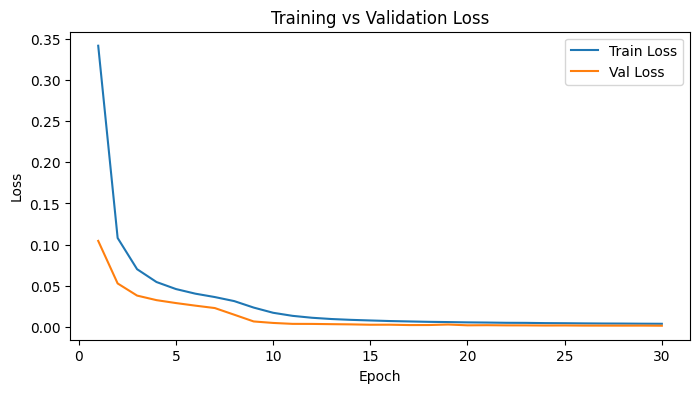

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS+1), val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [14]:
# token2idx/json 저장/로드가 필요하면 Colab에 맞게 추가하세요.
idx2token = {idx:tok for tok,idx in token2idx.items()}

@torch.no_grad()
def infer_sequence(start_str, end_str, max_len=50):
    if start_str not in token2idx or end_str not in token2idx:
        raise ValueError("Unknown token(s).")
    sos, eos = token2idx['<SOS>'], token2idx['<EOS>']
    src_idxs = [sos, token2idx[start_str], token2idx[end_str], eos]
    src = torch.tensor([src_idxs], device=device)
    src_pad = create_padding_mask(src).to(device)

    # 디코더 입력 초기화
    ys = torch.tensor([[sos]], device=device)
    for i in range(max_len):
        tgt_pad = create_padding_mask(ys).to(device)
        out = model(src, ys, src_pad, tgt_pad, src_pad)  # (1, t, V)
        prob = out[:, -1, :].argmax(dim=-1)  # (1,)
        next_tok = prob.item()
        ys = torch.cat([ys, prob.unsqueeze(0)], dim=1)
        if next_tok == eos:
            break

    res = [idx2token[idx] for idx in ys.squeeze().tolist()[1:-1]]  # <SOS>, <EOS> 제외
    return res

# 테스트
print("Example:", infer_sequence('27117', '25112'))


Example: ['D=5', 'TYPE=Corridor', 'TURN_RIGHT', 'D=5', 'TYPE=Corridor', 'TURN_LEFT', 'D=5', 'TYPE=Door', 'D=50', 'TYPE=Outside', 'D=25', 'TYPE=Door', 'D=5', 'TYPE=Corridor', 'TURN_LEFT', 'D=25', 'TYPE=Corridor', 'TURN_LEFT', 'D=5', 'TYPE=Room', 'END']


Val exact-match: 100%|██████████| 739/739 [00:14<00:00, 51.56it/s]


=== Length-wise Exact Sequence Match Accuracy ===
Length  5:    0/   1 =  0.00%
Length  6:    1/  45 =  2.22%
Length  9: 1103/1442 = 76.49%
Length 11:   21/  23 = 91.30%
Length 12: 1624/1667 = 97.42%
Length 13:    6/   6 = 100.00%
Length 14:   32/  33 = 96.97%
Length 15:  504/ 533 = 94.56%
Length 16:  224/ 224 = 100.00%
Length 17:   10/  10 = 100.00%
Length 18:  388/ 389 = 99.74%
Length 19: 2020/2085 = 96.88%
Length 20:  126/ 128 = 98.44%
Length 21: 1665/1703 = 97.77%
Length 22: 2740/2811 = 97.47%
Length 23: 1057/1075 = 98.33%
Length 24: 1869/1917 = 97.50%
Length 25: 1487/1566 = 94.96%
Length 26: 1386/1410 = 98.30%
Length 27:  808/ 855 = 94.50%
Length 28: 1078/1117 = 96.51%
Length 29:  659/ 697 = 94.55%
Length 30:  569/ 572 = 99.48%
Length 31:  559/ 566 = 98.76%
Length 32:  346/ 346 = 100.00%
Length 33:  362/ 363 = 99.72%
Length 34:  230/ 231 = 99.57%
Length 35:  373/ 374 = 99.73%
Length 36:  309/ 311 = 99.36%
Length 37:  510/ 518 = 98.46%
Length 38:  492/ 512 = 96.09%
Length 39:  665/

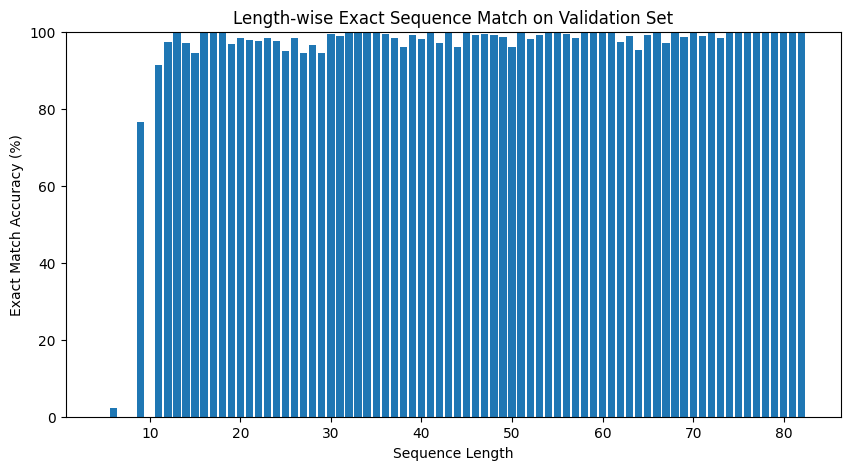


Overall Exact Match Accuracy: 46033/47266 = 97.39%


In [20]:
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1) 길이별 [맞힌_시퀀스수, 전체_시퀀스수] 저장
length_stats = defaultdict(lambda: [0, 0])

model.eval()
with torch.no_grad():
    for src, src_lens, tgt, tgt_lens in tqdm(val_loader, desc="Val exact-match"):
        src, tgt = src.to(device), tgt.to(device)
        src_pad = create_padding_mask(src).to(device)

        # 디코더 입력: <SOS> + 실제 토큰들, 마지막 <EOS> 제외
        dec_input = tgt[:, :-1]
        dec_pad   = create_padding_mask(dec_input).to(device)

        # 예측
        out   = model(src, dec_input, src_pad, dec_pad, src_pad)  # (B, T_dec, V)
        preds = out.argmax(dim=-1)                               # (B, T_dec)

        B = src.size(0)
        for i in range(B):
            L = tgt_lens[i].item() - 2            # <SOS>,<EOS> 제외한 토큰 개수
            true_seq = tgt[i, 1:1+L].tolist()     # positions 1..L
            pred_seq = preds[i, :L].tolist()      # positions 0..L-1

            length_stats[L][1] += 1
            if true_seq == pred_seq:
                length_stats[L][0] += 1

# 2) 결과 정리
lengths = sorted(length_stats)
exact_acc = [length_stats[L][0] / length_stats[L][1] * 100 for L in lengths]  # % 단위

print("=== Length-wise Exact Sequence Match Accuracy ===")
for L, acc in zip(lengths, exact_acc):
    print(f"Length {L:2d}: {length_stats[L][0]:4d}/{length_stats[L][1]:4d} = {acc:5.2f}%")

# 3) 막대그래프 그리기
plt.figure(figsize=(10,5))
plt.bar(lengths, exact_acc, width=0.8)
plt.xlabel("Sequence Length")
plt.ylabel("Exact Match Accuracy (%)")
plt.title("Length-wise Exact Sequence Match on Validation Set")
plt.ylim(0, 100)    # y축 최솟값을 0으로 고정
plt.show()

# 4) 전체 정확도 계산
total_correct   = sum(cnts[0] for cnts in length_stats.values())
total_sequences = sum(cnts[1] for cnts in length_stats.values())
overall_acc     = total_correct / total_sequences * 100

print(f"\nOverall Exact Match Accuracy: {total_correct}/{total_sequences} = {overall_acc:.2f}%")
